# Variational Quantum Eigensolver Tutorial

So you want to find the lowest eigenvalue/eigenvector of a very large matrix. Maybe that matrix represents the energy operator of some quantum system whose ground state you're interested in. Maybe you have other motives. Either way, since the matrix is very large, it's going to be inconvenient to directly solve for its eigenvalues and eigenvectors. On the other hand, if we actually had a quantum system, we could evaluate expectation values like $\langle \psi \mid H \mid \psi \rangle$. Could we use that to help us? 

Suppose we had some ansatz for the eigenvector that takes some parameters, for example, an angle $\theta$: $\mid \alpha(\theta) \rangle$. We could search over $\langle \alpha(\theta) \mid H \mid \alpha(\theta) \rangle$ until we find a value of $\theta$ that minimizes the expectation value of the operator, and then we've solved our problem.

In order to do this, however, we have to figure out how to actually measure $\langle \psi \mid H \mid \psi \rangle$ on our quantum computer. All we have are $n$ qubits, the ability to implement unitary gates, and the ability to measure each of the qubits along the $Z$ axis, obtaining a bit: $0$ or $1$. So what do we do?

<hr>

For example, suppose we have $H = \begin{pmatrix} 4 & -2i \\ 2i & 2 \end{pmatrix}$.

Let's stare at the Pauli matrices:

$I = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}, X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}, Y = \begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix}, Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $

After a while, we might realize that $H$ can be written $3 + 2Y + Z$.

$\begin{pmatrix} 4 & -2i \\ 2i & 2 \end{pmatrix} = 3\begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix} + 2\begin{pmatrix} 0 & -i \\ i & 0 \end{pmatrix} + \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix} $

By the laws of expectation values, it follows that:

$\langle H \rangle = 3+ 2\langle Y \rangle + \langle Z \rangle$

In other words, instead of measuring $\langle H \rangle$ directly, we could measure $\langle Y \rangle$ and $\langle Z \rangle$ separately (on separate preparations of the system), and add up the results, appropriately weighted, to obtain $\langle H \rangle$. In other words, we can split our expectation value into a weighted sum of expectation values of Pauli's.

Indeed, $I, X, Y, Z$ form a basis for $2 \times 2$ Hermitian operators, and so we can decompose any $2\times 2$ Hermitian operator into a sum as we did above: 

$H = \frac{tr(H)}{2}I + \frac{tr(XH)}{2}X + \frac{tr(YH)}{2}Y + \frac{tr(ZH)}{2}Z$


In [115]:
import numpy as np
import qutip as qt

########################################################################

def construct_pauli_basis():
    return {"I": qt.identity(2),\
            "X": qt.sigmax(),\
            "Y": qt.sigmay(),\
            "Z": qt.sigmaz()}

def op_pauli(O, basis):
    return dict([(s, (o.dag()*O).tr()/np.sqrt(len(basis)))\
                    for s, o in basis.items()])

def pauli_op(P, basis):
    return sum([P[s]*o for s, o in basis.items()])

def print_pauli(P):
    for s, v in P.items():
        if not np.isclose(v, 0):
            print("%s: %.2f" % (s, v.real))

########################################################################

basis = construct_pauli_basis()
H = qt.Qobj(np.array([[4, -2j],\
                      [2j, 2]]))
H_pauli = op_pauli(H, basis)
H2 = pauli_op(H_pauli, basis)

print("our matrix:")
print(H)
print("\npauli decomposition:")
print_pauli(H_pauli)
print("\nstill our matrix:")
print(H2)

our matrix:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[4.+0.j 0.-2.j]
 [0.+2.j 2.+0.j]]

pauli decomposition:
I: 3.00
Y: 2.00
Z: 1.00

still our matrix:
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[4.+0.j 0.-2.j]
 [0.+2.j 2.+0.j]]


We can check that $\langle H \rangle = 3+ 2\langle Y \rangle + \langle Z \rangle$.

In [116]:
# We take a sum over each operator and non-zero weight in the 
# Pauli decomposition. If we're dealing with the identity matrix, 
# we just add the weight to the sum; otherwise, we take the expectation value 
# of that Pauli operator, multiplied by its weight, and add that to the pile.
def expect(H, psi, basis):
    H_pauli = op_pauli(H, basis)
    return sum([v*(psi.dag()*basis[s]*psi\
                       if s.count("I") != len(s)\
                   else 1)\
                if not np.isclose(v, 0) else 0
                    for s, v in H_pauli.items()])[0,0].real
    
psi = qt.rand_ket(2)
print("<H> calculated the usual way: %.4f" % (psi.dag()*H*psi)[0,0].real)
print("<H> calculated the pauli way: %.4f" % expect(H, psi, IXYZ))

<H> calculated the usual way: 4.0923
<H> calculated the pauli way: 4.0923


<hr>

So we've reduced the problem of measuring $\langle H \rangle$ to that of measuring the $\langle X \rangle$/$\langle Y \rangle$/$\langle Z \rangle$'s separately (the constant term doesn't require any actual measurement). $\langle Z \rangle$ presents no problem for our quantum computer--it's the default: we simply prepare and measure some large number $N$ of identical copies of the initial qubit: we get $\uparrow$ or $\downarrow$ each time. Over the course of the experiments, we accumulate counts, the number $N_{\uparrow}$ and the number $N_{\downarrow}$, which we divide by the total number $N$ of experiments, to obtain the probabilities $p_{\uparrow} = \frac{N_{\uparrow}}{N}, p_{\downarrow} = \frac{N_{\downarrow}}{N}$. We associate $\uparrow$ with eigenvalue $\lambda_{\uparrow} = 1$ and $\downarrow$ with eigenvalue $\lambda_{\downarrow} = -1$, and sum them, weighted by their probabilities. This is the expectation value $\langle \psi \mid Z \mid \psi \rangle = (1)p_{\uparrow} + (-1)p_{\uparrow}$. You could just imagine: we write down a $1$ or a $-1$ depending on the outcome, and them sum them up and divide by $N$.

In [74]:
def expectZ(psi, n_shots=5000):
    dm = psi*psi.dag()
    return sum([np.random.choice([1, -1],\
                        p=[dm[0,0].real, dm[1,1].real])\
                    for i in range(n_shots)])/n_shots

psi = qt.rand_ket(2)
print("<Z> calculated the usual way: %.4f" % qt.expect(qt.sigmaz(), psi))
print("<Z> estimated stochastically: %.4f" % (expectZ(psi)))

<Z> calculated the usual way: 0.6643
<Z> estimated stochastically: 0.6724


<hr>

But what about $\langle X \rangle$ or $\langle Y \rangle$?

Recall that the probabilities are related to the complex amplitudes of the state vector: $p_{\uparrow} = |\alpha_{\uparrow}|^{2}$ and $p_{\downarrow} = |\alpha_{\downarrow}|^{2}$, for a qubit state $\begin{pmatrix} \alpha_{\uparrow} \\ \alpha_{\downarrow} \end{pmatrix}$ aka $\alpha_{\uparrow}\mid \uparrow \rangle +\alpha_{\uparrow}\mid \downarrow \rangle$, where $\uparrow$ and $\downarrow$ are in the $Z$ direction. The probabilities also appear as the diagonal entries of the density matrix, which for a pure state is $\mid \psi \rangle \langle \psi \mid$.

Such a state can be interpreted in terms of a point on the sphere, given by $(<X>, <Y>, <Z>)$, and a complex phase. The two complex orthogonal eigenstates of a Hermitian matrix (like $X$, $Y$, and $Z$) correspond to two antipodal points on the sphere.

Another way of thinking about this is in terms of the <a href="https://en.wikipedia.org/wiki/Stereographic_projection">stereographic projection</a>:

<a href="https://mathematica.stackexchange.com/questions/23793/stereographic-projection"><img style="margin: auto; width: 500px; display: block" src="https://i.stack.imgur.com/6zeHc.jpg"></a>

We determine a point on the plane by the ratio $\frac{\alpha_{\downarrow}}{\alpha_{\uparrow}}$: the $(x, y)$ coordinates are the real and imaginary parts of the ratio. We then project this point onto the unit sphere. Each point on the plane is mapped to a unique location on the sphere. If ${\alpha_{\uparrow}} = 0$, then we have an extra point, not on the plane, which corresponds to the pole of projection on the sphere. (The standard thing is to do the projection from the South Pole, despite the picture.)

The point is we can think of our qubit as picking out a rotation axis *built out of expectation values*. And indeed, if the qubit is measured along the axis it's pointed in, it remains in exactly that same state. Moreover, under the action of rotations, given by complex exponentials of Paulis, this expected axis rotates just as you'd expect (although, of course, there's more sublety regarding the phase!)

<hr>

So, if you think about it, we just have to do a rotation before our measurement. Suppose our qubit is pointing up in the $Y^{+}$ direction, so a $Y$ measurement should give $\uparrow$ every time. But we're only allowed $Z$ measurements. We can get the same effect as a $Y$ measurement by first doing a rotation of $90^{\circ}$ aka $\frac{\pi}{2}$ around the $X$ axis, which rotates $Y^{+}$ into $Z^{+}$ (and $Y^{-}$ into $Z^{-}$). So we can turn a $Z$ measurement into a $Y$ measurement by first applying $R_{x}(\frac{\pi}{2}) = e^{-\frac{\pi}{4}iX}$ to our qubit $\mid \psi \rangle$, and then measuring.

Similarly, if we had to measure $\langle X \rangle$, we could apply $R_{y}(-\frac{\pi}{2}) = e^{\frac{\pi}{4}}iY$, rotating the opposite way a quarter turn around the $Y$ axis, to rotate $X^{+}$ into $Z^{+}$, etc.

In [75]:
def qubit_xyz(qubit):
    return [qt.expect(qt.sigmax(), qubit),\
            qt.expect(qt.sigmay(), qubit),\
            qt.expect(qt.sigmaz(), qubit)]

# If you need <X> -> Ry
Xp = (qt.basis(2,0)+qt.basis(2,1)).unit()
print("X+: %s" % qubit_xyz(Xp))
print("rotates to: %s" % qubit_xyz((1j*qt.sigmay()*np.pi/4).expm()*Xp))
print()
# If you need <Y> -> Rx
Yp = (qt.basis(2,0)+1j*qt.basis(2,1)).unit()
print("Y+: %s" % qubit_xyz(Yp))
print("rotates to: %s" % qubit_xyz((-1j*qt.sigmax()*np.pi/4).expm()*Yp))

X+: [0.9999999999999998, 0.0, 0.0]
rotates to: [0.0, 0.0, 1.0]

Y+: [0.0, 0.9999999999999998, 0.0]
rotates to: [0.0, 0.0, 1.0]


In [77]:
print("<X> calculated the usual way: %.4f" % qt.expect(qt.sigmax(), psi))
print("<X> estimated stochastically: %.4f" % expectZ((1j*qt.sigmay()*np.pi/4).expm()*psi))
print()
print("<Y> calculated the usual way: %.4f" % qt.expect(qt.sigmay(), psi))
print("<Y> estimated stochastically: %.4f" % expectZ((-1j*qt.sigmax()*np.pi/4).expm()*psi))

<X> calculated the usual way: -0.4919
<X> estimated stochastically: -0.5000

<Y> calculated the usual way: -0.5628
<Y> estimated stochastically: -0.5732


Putting it together, we decompose our matrix into a sum of Pauli's, and then for each term in this sum, we do a separate experiment (state preparation, pre-measurement rotation, measurement) many times, to accumulate the expectation value of that Pauli. We add 'em all up, each with their weight, which gives us the expectation value of the original matrix on that state. 

In [78]:
def expect(H, psi, basis):
    Rmap = {"I": qt.identity(2),\
            "X": (1j*qt.sigmay()*np.pi/4).expm(),\
            "Y": (-1j*qt.sigmax()*np.pi/4).expm(),\
            "Z": qt.identity(2)}
    H_pauli = op_pauli(H, basis)
    return sum([v*(stochastic(Rmap[s]*psi)\
                       if s.count("I") != len(s)\
                   else 1)\
                if not np.isclose(v, 0) else 0
                    for s, v in H_pauli.items()])

print("<H> calculated the usual way: %.4f" % qt.expect(H, psi))
print("<H> estimated stochastically: %.4f" % expect(H, psi, IXYZ))

<H> calculated the usual way: 2.5388
<H> estimated stochastically: 2.5324


<hr>

So all that's great, but what if we have multiple qubits, say $n$?

Well, it turns out that strings of Paulis of length $n$ also form a basis for Hermitian matrices, in this case, $2^{n} \times 2^{n}$ dim matrices. By a "string," I mean, a tensor product of Paulis, e.g.:

$XYYZIIIX$ means: $X \otimes Y \otimes Y \otimes Z \otimes I \otimes I \otimes I \otimes X$.

For two qubits, we have the 16 matrices:

$\begin{matrix} II & IX & IY & IZ \\
                XI & XX & XY & XZ \\
                YI & YX & YY & YZ \\
                ZI & ZX & XY & ZZ \end{matrix}$

Thus we can decompose an $n$-qubit operator just as easily as before:

In [79]:
from itertools import product

def construct_pauli_basis(n):
    IXYZ = {"I": qt.identity(2),\
            "X": qt.sigmax(),\
            "Y": qt.sigmay(),\
            "Z": qt.sigmaz()}
    return dict([("".join(p),\
                  qt.tensor(*[IXYZ[s] for s in p]))\
                for p in product(IXYZ.keys(), repeat=n)])

n = 2
basis = construct_pauli_basis(n)
H = qt.Qobj(np.array([[1,0,0,0],\
                      [0,0,-1,0],\
                      [0,-1,0,0],\
                      [0,0,0,1]]))
H.dims = [[2]*n, [2]*n]
H_pauli = op_pauli(H, basis)
H2 = pauli_op(H_pauli, basis)

print("our matrix:")
print(H)
print("\npauli decomposition:")
print_pauli(H_pauli)
print("\nstill our matrix:")
print(H2)

our matrix:
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

pauli decomposition:
II: 0.50
XX: -0.50
YY: -0.50
ZZ: 0.50

still our matrix:
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]


In other words, we could perform the following decomposition:

$H = \begin{pmatrix}1 & 0 & 0 & 0\\ 
0 & 0 & -1 & 0\\ 
0 & -1 & 0 & 0\\ 
0 & 0 & 0 & 1\end{pmatrix} = \frac{1}{2} -\frac{1}{2}XX -\frac{1}{2}YY + \frac{1}{2}ZZ $

The expectation value becomes:

$\langle H \rangle = \frac{1}{2} -\frac{1}{2}\langle XX \rangle -\frac{1}{2} \langle YY \rangle + \frac{1}{2} \langle ZZ \rangle$

<hr>

Now it is a fact that $A \otimes B \mid \alpha \rangle \mid \beta \rangle = A\mid \alpha \rangle \otimes B \mid \beta \rangle$ for unitaries $A$ and $B$. In other words, $A \otimes B$ on a separable state just transforms $\mid \alpha \rangle$ by $A$ and $\mid \beta \rangle$ by $B$. One thing this implies is that the tensor products of $A$ and $B$'s eigenvectors are also eigenvectors of $A \otimes B$. Moreover, the corresponding eigenvalues of $A \otimes B$ are given by the products of $A$ and $B$ eigenvalues.

In [98]:
XY = qt.tensor(qt.sigmax(), qt.sigmay())
Xl, Xv = qt.sigmax().eigenstates()
Yl, Yv = qt.sigmay().eigenstates()

l, v = [], []
for i in range(2):
    for j in range(2):
        l.append(Xl[i]*Yl[j]) # product of eigenvalues
        v.append(qt.tensor(Xv[i],Yv[j])) # tensor product of eigenvectors

print("XY eigenvalues: %s\n" % l)
for v_ in v:
    print("XY eigenvector / XY on eigenvector:")
    print(np.concatenate([v_.full(), (XY*v_).full()], axis=1))
    print()

XY eigenvalues: [1.0, -1.0, -1.0, 1.0]

XY eigenvector / XY on eigenvector:
[[ 0.5+0.j   0.5+0.j ]
 [ 0. -0.5j  0. -0.5j]
 [-0.5+0.j  -0.5+0.j ]
 [ 0. +0.5j  0. +0.5j]]

XY eigenvector / XY on eigenvector:
[[ 0.5+0.j  -0.5+0.j ]
 [ 0. +0.5j  0. -0.5j]
 [-0.5+0.j   0.5+0.j ]
 [ 0. -0.5j  0. +0.5j]]

XY eigenvector / XY on eigenvector:
[[-0.5+0.j   0.5+0.j ]
 [ 0. +0.5j  0. -0.5j]
 [-0.5+0.j   0.5+0.j ]
 [ 0. +0.5j  0. -0.5j]]

XY eigenvector / XY on eigenvector:
[[-0.5+0.j  -0.5+0.j ]
 [ 0. -0.5j  0. -0.5j]
 [-0.5+0.j  -0.5+0.j ]
 [ 0. -0.5j  0. -0.5j]]



You might notice, however, that:

In [99]:
XY.eigenstates()

(array([-1., -1.,  1.,  1.]),
 array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.70710678+0.j        ]
  [0.        +0.j        ]
  [0.        +0.j        ]
  [0.        -0.70710678j]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        +0.j        ]
  [0.        -0.70710678j]
  [0.70710678+0.j        ]
  [0.        +0.j        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[-0.70710678+0.j        ]
  [ 0.        +0.j        ]
  [ 0.        +0.j        ]
  [ 0.        -0.70710678j]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        +0.j        ]
  [0.        +0.70710678j]
  [0.70710678+0.j        ]
  [0.        +0.j        ]]], dtype=object))

gives different eigenstates!

Yet:

In [106]:
XYl, XYv = XY.eigenstates()
for i, v_ in enumerate(v):
    print("XY eigvec (%.2f) / in alternate basis:" % (l[i]))
    print(np.concatenate([v_.full(), (v_.transform(XYv)).full()], axis=1))
    print()

XY eigvec (1.00) / in alternate basis:
[[ 0.5       +0.j   0.        +0.j ]
 [ 0.        -0.5j  0.        +0.j ]
 [-0.5       +0.j  -0.70710678+0.j ]
 [ 0.        +0.5j -0.70710678+0.j ]]

XY eigvec (-1.00) / in alternate basis:
[[ 0.5       +0.j   0.70710678+0.j ]
 [ 0.        +0.5j -0.70710678+0.j ]
 [-0.5       +0.j   0.        +0.j ]
 [ 0.        -0.5j  0.        +0.j ]]

XY eigvec (-1.00) / in alternate basis:
[[-0.5       +0.j  -0.70710678+0.j ]
 [ 0.        +0.5j -0.70710678+0.j ]
 [-0.5       +0.j   0.        +0.j ]
 [ 0.        +0.5j  0.        +0.j ]]

XY eigvec (1.00) / in alternate basis:
[[-0.5       +0.j   0.        +0.j ]
 [ 0.        -0.5j  0.        +0.j ]
 [-0.5       +0.j   0.70710678+0.j ]
 [ 0.        -0.5j -0.70710678+0.j ]]



In the alternate basis, the components are associated with the eigenvalues in order $\{-1, -1, 1, 1\}$.

Each of the tensor product eigenstates, in the basis provided by the eigenstates calculated by qutip, lives either in the $1$ or $-1$ sector: in other words, can be written as a sum of eigenstates in the other basis with the same eigenvalue, indeed, the same eigenvalue associated with the tensor product state. So the ambiguity is due to the degeneracy of the eigenvalues. 

In any case, we're good to go!

<hr>


If we have multiple qubits, for each Pauli string in the decomposition of our operator, e.g., $XYY$, we want to follow the same rule as before, just on each of the qubits. Recall:

$X \rightarrow R_{y}(-\frac{\pi}{2}) = e^{\frac{\pi}{4}}iY$

$Y \rightarrow R_{x}(\frac{\pi}{2}) = e^{-\frac{\pi}{4}iX}$

So for $XYY$,  we'd do a $Z$ measurement on each of the qubits in turn, but first: a rotation $R_{y}(-\frac{\pi}{2})$ on the first qubit, and a rotation $R_{x}(\frac{\pi}{2})$ on the second two.

Upon measurement, we get three bits, e.g., $1, -1, 1$, representing the results of a $Z$ measurement on each of the three qubits. We multiply these three eigenvalues together, to get the eigenvalue of the whole state: $-1$. We add it to the pile, and then repeat the experiment thousands of times, eventually dividing by the number of experiments. And then we have the expectation value of that Pauli operator, which then is weighted in the sum which gives the expectation value of the original operator.

In [88]:
# Tensors an operator appropriately with the identity so that it acts
# on the i-th of n subsystems.
def upgrade(op, i, n):
    return qt.tensor(*[op if i == j \
                          else qt.identity(op.shape[0])\
                                for j in range(n)])

# Expectation value of Z measurements on n qubits.
# If stochastic == False, we simply calculate the expectation value 
# of the ...ZZZ... operator on the state in the usual way. 
# Otherwise: For n_shots, we iterate over the qubits, calculating 
# the density matrix of each qubit by a partial trace,
# extracting the probabilities for a Z measurement  
# from its diagonal entries. We flip a coin and randomly select
# an eigenvalue {1, -1}. We project that qubit into the
# corresponding Z eigenstate, and move onto the next.
# Once we've gone through all the qubits, we multiply
# all the eigenvalues together to get the eigenvalue
# of the whole state, and add that to our running total,
# which, after n_shots, we divide by n_shots to get our
# expectation value.
def expectZ(qubits, n_shots=1024, stochastic=True):
    n = len(qubits.dims[0])
    if not stochastic:
        return qt.expect(qt.tensor(*[qt.sigmaz()]*n), qubits)
    running = 0
    Zp = [v*v.dag() for v in qt.sigmaz().eigenstates()[1]]
    for i in range(n_shots):
        choices = []
        state = qubits.copy()
        for j in range(n):
            dm = state.ptrace(j)
            choice = np.random.choice([1, -1], p=[dm[0,0].real, dm[1,1].real])
            choices.append(choice)
            state = (upgrade(Zp[0 if choice == -1 else 1], j, n)*state).unit()
        running += np.prod(choices)
    running = running/n_shots
    return running

def expect(H, psi, basis, stochastic=True):
    Rmap = {"I": qt.identity(2),\
            "X": (1j*qt.sigmay()*np.pi/4).expm(),\
            "Y": (-1j*qt.sigmax()*np.pi/4).expm(),\
            "Z": qt.identity(2)}
    H_pauli = op_pauli(H, basis)
    return sum([v*(expectZ(\
                        qt.tensor(*[Rmap[o] for o in s])*psi,\
                        stochastic=stochastic)\
                            if s.count("I") != len(s)\
                   else 1)\
                if not np.isclose(v, 0) else 0
                    for s, v in H_pauli.items()])

psi = qt.rand_ket(4)
psi.dims = [[2,2],[1,1]]
print("<H> calculated the usual way: %.4f" % qt.expect(H, psi))
print("<H> estimated stochastically: %.4f" % expect(H, psi, basis))

<H> calculated the usual way: 0.2365
<H> estimated stochastically: 0.2812


<hr>

So we can take expectation values to our heart's content. Now we turn to issue of parameterizing the state.

As before, we're working with:

$H = \begin{pmatrix}1 & 0 & 0 & 0\\ 
0 & 0 & -1 & 0\\ 
0 & -1 & 0 & 0\\ 
0 & 0 & 0 & 1\end{pmatrix} = \frac{1}{2} -\frac{1}{2}XX -\frac{1}{2}YY + \frac{1}{2}ZZ $

We'll take as our ansatz for the state: 

$\mid \psi(\theta) \rangle = (R_{x}(\theta) \otimes I)(CNOT)(h \otimes I)\mid \uparrow \uparrow \rangle$

Here, $h = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$, the Hadamard gate, aka the Fourier Transform operator ($h^{\dagger}Xh = Z$).

$CNOT = \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{pmatrix}$ is the controlled-$X$ or controlled-$NOT$ gate, which flips the second qubit if the first qubit is $\mid \downarrow \rangle$. Acting on $\mid \uparrow \uparrow \rangle$, $h$ takes the first qubit to an equal superposition of $\uparrow$ and $\downarrow$: in other words, from $Z^{+}$ to $X^{+}$. Then the $CNOT$ conditions the flippage of the second qubit on the first qubit which is in a superposition. This leads to the maximally entangled state: $\frac{1}{\sqrt{2}} (\mid \uparrow \uparrow \rangle + \mid \downarrow \downarrow \rangle)$. Finally, we perform a rotation of the first qubit around the $X$ axis by some angle $\theta$, which allows us to parameterize all manner of maximally entangled states, from correlated to anticorrelated.

Then we can then iterate over values of $\theta$ to try and find our ground state.

<hr>

Putting it all together:


our matrix:
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

compare:
lowest eigval =  -1.0000
eigenvector = 
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]]

theta = 0.0000, <H> = 1.0000
theta = 0.3307, <H> = 0.9458
theta = 0.6614, <H> = 0.7891
theta = 0.9921, <H> = 0.5469
theta = 1.3228, <H> = 0.2455
theta = 1.6535, <H> = -0.0826
theta = 1.9842, <H> = -0.4017
theta = 2.3149, <H> = -0.6773
theta = 2.6456, <H> = -0.8795
theta = 2.9762, <H> = -0.9864
theta = 3.3069, <H> = -0.9864
theta = 3.6376, <H> = -0.8795
theta = 3.9683, <H> = -0.6773
theta = 4.2990, <H> = -0.4017
theta = 4.6297, <H> = -0.0826
theta = 4.9604, <H> = 0.2455
theta = 5.2911, <H> = 0.5469
theta = 5.6218, <H> = 0.7891
theta = 5.9525, <H> = 0.9458
theta = 6.2832, <H> = 1.0000

final theta = 3.3069, <H> = -0.9864


Text(0, 0.5, '<H>')

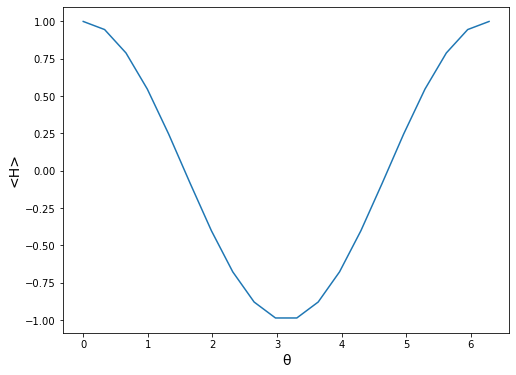

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
from qutip.qip.operations import cnot, hadamard_transform

########################################################################

def ansatz(theta):
    vac = qt.basis(4,0)
    vac.dims = [[2,2], [1,1]]
    return qt.tensor((-1j*qt.sigmax()*theta/2).expm(), qt.identity(2))*\
           cnot()*\
           qt.tensor(hadamard_transform(), qt.identity(2))*\
           vac

########################################################################

print("our matrix:")
H = qt.Qobj(np.array([[1,0,0,0],\
                      [0,0,-1,0],\
                      [0,-1,0,0],\
                      [0,0,0,1]]))
H.dims = [[2]*n, [2]*n]
print(H)

Hl, Hv = H.eigenstates()
print("\ncompare:")
print("lowest eigval =  %.4f" % (Hl[0]))
print("eigenvector = \n%s" % (Hv[0]))
print()

########################################################################

basis = construct_pauli_basis(2)

samples = 20
stochastic = False
verbose = True

expectation_values = []
thetas = np.linspace(0, 2*np.pi, samples)
for theta in thetas:
    expectation_values.append(expect(H, ansatz(theta), basis, stochastic=stochastic))
    print("theta = %.4f, <H> = %.4f" % (theta, expectation_values[-1])) if verbose else None
least_index = np.argmin(expectation_values)

final_theta = thetas[least_index]
final_vector = ansatz(final_theta)
print("\nfinal theta = %.4f, <H> = %.4f" % (final_theta, expectation_values[least_index]))
print("final vector =\n%s" % ansatz(final_theta))

########################################################################

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(thetas, expectation_values)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('<H>', fontsize=14)

<hr>

That's all well and good, but let's actually run this baby on a quantum computer.

We use IBM's framekwork qiskit. The algorithm directly translates over, although we construct all the circuits ahead of time, transpile/simplify them, and then send them in bulk to the quantum computer (or classical simulator), divvied up into several "jobs."

Make sure to have an <a href="https://quantum-computing.ibm.com/">account</a> with IBM, and replace ```YOUR_TOKEN``` to run things non-locally.

our matrix:
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  0.  1.]]

compare:
lowest eigval =  -1.0000
eigenvector = 
Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]]

laying out circuits...
evaluating...

theta = 0.0000, <H> = 1.00000000
theta = 0.1065, <H> = 0.99389648
theta = 0.2130, <H> = 0.97900391
theta = 0.3195, <H> = 0.94750977
theta = 0.4260, <H> = 0.91528320
theta = 0.5325, <H> = 0.86572266
theta = 0.6390, <H> = 0.80053711
theta = 0.7455, <H> = 0.72949219
theta = 0.8520, <H> = 0.67089844
theta = 0.9585, <H> = 0.57885742
theta = 1.0649, <H> = 0.48583984
theta = 1.1714, <H> = 0.39233398
theta = 1.2779, <H> = 0.30102539
theta = 1.3844, <H> = 0.17846680
theta = 1.4909, <H> = 0.08813477
theta = 1.5974, <H> = -0.00512695
theta = 1.7039, <H> = -0.12915039
theta = 1.8104, <H> = -0.2

Text(0, 0.5, '<H>')

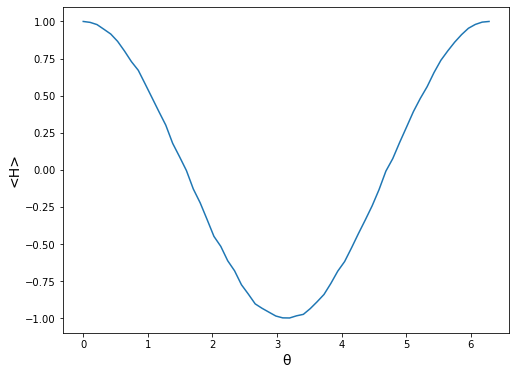

In [113]:
%matplotlib inline
import numpy as np
import qutip as qt
from math import pi
from itertools import *
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute
from qiskit import Aer, IBMQ, transpile
from qiskit.providers.ibmq.managed import IBMQJobManager

#IBMQ.save_account('YOUR_TOKEN')

samples = 60
n_shots = 4096
classical = False # if True, uses "ibmq_qasm_simulator" 
quantum = False # if True, uses "ibmq_vigo"

# Or: set local to False, and specify particular backend.
local = True 
backend_name = "ibmq_5_yorktown" #"ibmq_16_melbourne", etc.

##############################################################################

# For each Pauli string of the form "XIXXY", of length n,
# construct the tensor product of the corresponding
# Pauli operators. These form a basis for 2^n x 2^n Hermitian matrices.
def construct_pauli_basis(n):
    IXYZ = {"I": qt.identity(2),\
            "X": qt.sigmax(),\
            "Y": qt.sigmay(),\
            "Z": qt.sigmaz()}
    return dict([("".join(p),\
                  qt.tensor(*[IXYZ[s] for s in p]))\
                for p in product(IXYZ.keys(), repeat=n)])

# Find the components of an operator in the Pauli basis.
def op_pauli(O, basis):
    return dict([(s, (o.dag()*O).tr()/np.sqrt(len(basis)))\
                    for s, o in basis.items()])

# Recovers the original matrix from the Pauli components.
def pauli_op(P, basis):
    return sum([P[s]*o for s, o in basis.items()])

# Pretty print for the Pauli decomposition.
def print_pauli(P):
    for s, v in P.items():
        if not np.isclose(v, 0):
            print("%s: %.2f" % (s, v))

##############################################################################

if quantum:
    local = False
    backend_name = "ibmq_vigo"
    
if classical:
    local = False
    backed_name = "ibmq_qasm_simulator"

##############################################################################

print("our matrix:")
H = qt.Qobj(np.array([[1,0,0,0],\
                      [0,0,-1,0],\
                      [0,-1,0,0],\
                      [0,0,0,1]]))
H.dims = [[2]*2, [2]*2]
print(H)
Hl, Hv = H.eigenstates()

# Let's make sure we know the right answer.
print("\ncompare:")
print("lowest eigval =  %.4f" % (Hl[0]))
print("eigenvector = \n%s" % (Hv[0]))
print()

basis = construct_pauli_basis(2)
H_pauli = op_pauli(H, basis)

##############################################################################

def ansatz(theta):
    circ = QuantumCircuit(2)
    circ.h(0)
    circ.cx(0,1)
    circ.rx(theta, 0)
    return circ

##############################################################################

if local:
    backend = Aer.get_backend('qasm_simulator')
else:    
    provider = IBMQ.load_account()
    job_manager = IBMQJobManager()
    backend = provider.get_backend(backend_name)

print("laying out circuits...")
# Creates circuits: for each theta, we run through all the operators 
# in the Pauli decomposition, and create a circuit for each one
# that starts with the ansatz, then consists of pre-measurement
# rotations on each of the qubits, and then a full measurement.
circs = []
circ_indices = []
thetas = np.linspace(0, 2*np.pi, samples)
for t in thetas:
    for n, v in H_pauli.items():
        if not np.isclose(v, 0):
            circ = ansatz(t)
            for i, o in enumerate(n):
                if o == "X":
                    circ.ry(-pi/2, i)
                elif o == "Y":
                    circ.rx(pi/2, i)
            circ.measure_all()
            circs.append(circ)
            circ_indices.append((t, n))

print("evaluating...\n")
# We optimize the circuits, and send them off to be evaluated.
circs = transpile(circs, backend=backend)
jb = execute(circs, backend, shots=n_shots) if local \
        else job_manager.run(circs, backend=backend, name='vqe', shots=n_shots) 
jb_results = jb.result() if local else jb.results()

# We run through the results. For each Pauli operator P in the
# decomposition, we get the counts which, when converted into probabilities,
# weight the eigenvalues, which are the product of the {-1, 1}'s of each
# qubit. We weight each of these ...Z... expectation values by
# the component of P in the Pauli decomposition, and sum to get the 
# full expectation value.
# We do this for each theta, and find the theta with the least <H>.
expectation_values = []
for t in thetas:
    values = []
    for n, v in H_pauli.items():
        if not np.isclose(v, 0):
            if n.count("I") == len(n):
                values.append(H_pauli[n])
            else:
                counts = jb_results.get_counts(circ_indices.index((t, n)))
                values.append(\
                    H_pauli[n]*\
                        sum([(c/n_shots)*\
                                np.prod([1 if s_=='1' \
                                            else -1 for s_ in s])\
                        for s, c in counts.items()])\
                    )
    e = sum(values)
    print("theta = %.4f, <H> = %.8f" % (t, e))
    expectation_values.append(e)
min_result = np.argmin(expectation_values)
final_theta = thetas[min_result]
print("\nfinal_theta: %.4f, <H> = %.4f" % (final_theta, expectation_values[min_result]))

# Use a statevector simulator to look at our final state.
state_backend = Aer.get_backend('statevector_simulator')
state = execute(ansatz(final_theta), backend=state_backend).result().get_statevector()
print("final vector = \n%s" % qt.Qobj(state))

# Plot!
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(thetas, expectation_values)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('<H>', fontsize=14)

We can check out the transpiled circuits:

In [114]:
[circ.draw() for circ in circs[:10]]

[        ┌───┐      ░ ┌─┐   
    q_0: ┤ H ├──■───░─┤M├───
         └───┘┌─┴─┐ ░ └╥┘┌─┐
    q_1: ─────┤ X ├─░──╫─┤M├
              └───┘ ░  ║ └╥┘
 meas: 2/══════════════╩══╩═
                       0  1 ,
         ┌───┐     ┌────────────┐ ░ ┌─┐   
    q_0: ┤ H ├──■──┤ U2(pi,-pi) ├─░─┤M├───
         └───┘┌─┴─┐├────────────┤ ░ └╥┘┌─┐
    q_1: ─────┤ X ├┤ U2(pi,-pi) ├─░──╫─┤M├
              └───┘└────────────┘ ░  ║ └╥┘
 meas: 2/════════════════════════════╩══╩═
                                     0  1 ,
         ┌───┐     ┌────────────────┐ ░ ┌─┐   
    q_0: ┤ H ├──■──┤ U2(-pi/2,pi/2) ├─░─┤M├───
         └───┘┌─┴─┐├────────────────┤ ░ └╥┘┌─┐
    q_1: ─────┤ X ├┤ U2(-pi/2,pi/2) ├─░──╫─┤M├
              └───┘└────────────────┘ ░  ║ └╥┘
 meas: 2/════════════════════════════════╩══╩═
                                         0  1 ,
         ┌───┐      ░ ┌─┐   
    q_0: ┤ H ├──■───░─┤M├───
         └───┘┌─┴─┐ ░ └╥┘┌─┐
    q_1: ─────┤ X ├─░──╫─┤M├
              └───┘ ░  ║ └╥┘
 meas: 2/══════════

<hr>

So in the end, the answer is: when $\theta = \pi$, the ansatz is $-\frac{i}{\sqrt{2}} \begin{pmatrix} 0 \\ 1 \\ 1 \\ 0 \end{pmatrix}$, which corresponds (up to phase) to the lowest eigenstate of $H$ with eigenvalue $-1$. We could imagine more sophisticated schemes, involving more elaborate ansatze, using fancier algorithms to search through the parameters, from gradient descent onward, generating thousands upon thousands of circuits that when implemented thousands upon thousands of times allow one to estimate the lowest eigenvalue/eigenvector of a matrix faster than a classical computer.

Special thanks to <a href="https://qosf.org/">qosf</a>, and <a href="https://www.mustythoughts.com/variational-quantum-eigensolver-explained">this</a>.